# Classification of Invasive Ductal Carcinoma Using Breast Histology Images

#### Student name(s):
* Sencer Kaya - 21727427

#### Abstract
Invasive Ductal Carcinoma (IDC) is the most common type of breast cancer begins when an abnormal cell development happens in the milk duct tissue which leads to an uncontrolled growth of cancerous cells around the surrounding breast tissue. In this project, my goal is to make an accurate classification model using publicly available dataset of breast histology images. I am going to train Deep Learning models using Convolutional Neural Networks to accomplish my goal in this project.

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>

Invasive Ductal Carcinoma (IDC), otherwise known as Infiltrating Ductal Carcinoma, is a subtype of breast cancer disease that mostly affects female population. Like all other cancer diseases, it is caused by uncontrollable and abnormal cell division that is spreading into the surrounding tissues. It starts in the milk ducts near the breast tissue and spreads trough body or nearby tissue by metastasize. It is the most common subtype of all breast cancer by forming up the 3/4th of the breast cancer cases according to the American Cancer Society. The American Cancer Society reported an estimation about 287,850 new cases of invasive breast cancers diagnosed in the U.S. at year 2022.

In many cases, IDC shows no signs and symptoms noticable by the patient in the early stages their your doctor comes accross with a malignant looking area on a breast screening mammogram. However, when we look the statistics about survival rates of IDC, we can see that five-year survival rate for localized IDC is nearly 100% if it is diagnosed and treated in the early stages of the disease. Survival rate of the disease decreases by the stage of the disease when it is diagnosed, such as in the cases of locally spread case the five-year survival rate being 86%. The term "invasive" indicates that the cancer was already spread locally, by the time of the diagnosis. If not treated early on, IDC can spread into the various areas of the body such as liver, lungs or brain by travelling through lenf nodes and blood stream.

<img src="https://i.imgur.com/g4nmZzz.png" alt="Ductal Carcinoma Explanatory Image" width="300"/>

Since the early diagnosis leads to early treatment which plays very important role in increasing survival rate of patients as explained above, an automatic detection mechanism using Machine Learning and/or Deep Learning techniques would be very useful if applied to tissues Whole Slide Histopathology Image of breast tissue by the hospitals for automatically classifying breast microscopic tissues to distinguish IDC just in case. Even if they are needed for some else prognosis procedure. 

## Data Understanding<a class="anchor" id="data_understanding"></a>

The original dataset consisted of 162 pieces of Whole Slide Images (WSI) of breast cancer samples obtained from 162 patients diagnosed with IDC at the Hospital of the University of Pennsylvania and The Cancer Institute of New Jersey. These Whole Slide Histopathology Images were scanned and digitized at 40x magnification. To provide a ground truth for machine learning algorithms, these WSI are annotated and labeled by manual delineation of the cancer region by an expert pathologist.

Original dataset can be acquired from here : [Dataset Link](http://www.andrewjanowczyk.com/use-case-6-invasive-ductal-carcinoma-idc-segmentation/)

The actual dataset I am going to use can be called as subset of this original dataset. From the original dataset, 277,524 patches of WSI were extracted at 50 pixels by 50 pixels RGB, resulting 198,738 IDC-Negative and 78,786 IDC-Positive patches. Afterwards, smaller version of this dataset is published on Kaggle referenced right below as modified dataset. Randomly selected 2759 IDC-Positive and 2788 IDC-Negative WSI patches sized 50 pixels by 50 pixels RGB are published as numpy array (ndarray) along with their binary labeling numpy array who has same indices referring to the 50x50x3 patches.

Modified dataset I actually use can be acquired from here : [Dataset Link](https://www.kaggle.com/datasets/simjeg/lymphoma-subtype-classification-fl-vs-cll)

* Importing the libraries I am going to use throughout the project:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import random
import torch
import torchvision
import sklearn

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D,
                          Activation, Dropout, Flatten, Dense)
from keras.regularizers  import l1_l2
from keras.optimizers import RMSprop
from PIL import Image

TORCH_DEV = 'cuda' if torch.cuda.is_available() else 'cpu'
dev = torch.device(TORCH_DEV)

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Seperating the numpy array that holds the image patches into two different numpy arrays by filtering them using label array:

In [ ]:
histology_patches = np.load('/content/drive/MyDrive/archive/X.npy')
labels = np.load('/content/drive/MyDrive/archive/Y.npy')

non_idc_patches = histology_patches[labels == 0]
idc_positive_patches = histology_patches[labels == 1]

* Providing an overview by printing some numerical statistical value about the dataset:

In [ ]:
print('Shape of the ndarray that holds 50 x 50 x 3 patches \t\t= {}'.format(histology_patches.shape))
print('Numpy Array that holds the binary labels of patches \t\t= {}'.format(np.array2string(labels)))
print('Total number of IDC related breast histology image patches is \t= {}'.format(len(histology_patches)))
print('Ratio of IDC-Positive patches to IDC-Negative patches is \t= {} / {}'.format(len(non_idc_patches), len(idc_positive_patches)))

Shape of the ndarray that holds 50 x 50 x 3 patches 		= (5547, 50, 50, 3)
Numpy Array that holds the binary labels of patches 		= [0 0 0 ... 1 1 1]
Total number of IDC related breast histology image patches is 	= 5547
Ratio of IDC-Positive patches to IDC-Negative patches is 	= 2759 / 2788


* Randomly selected patches from both IDC-Positive and IDC-Negative sets are shown for insight:

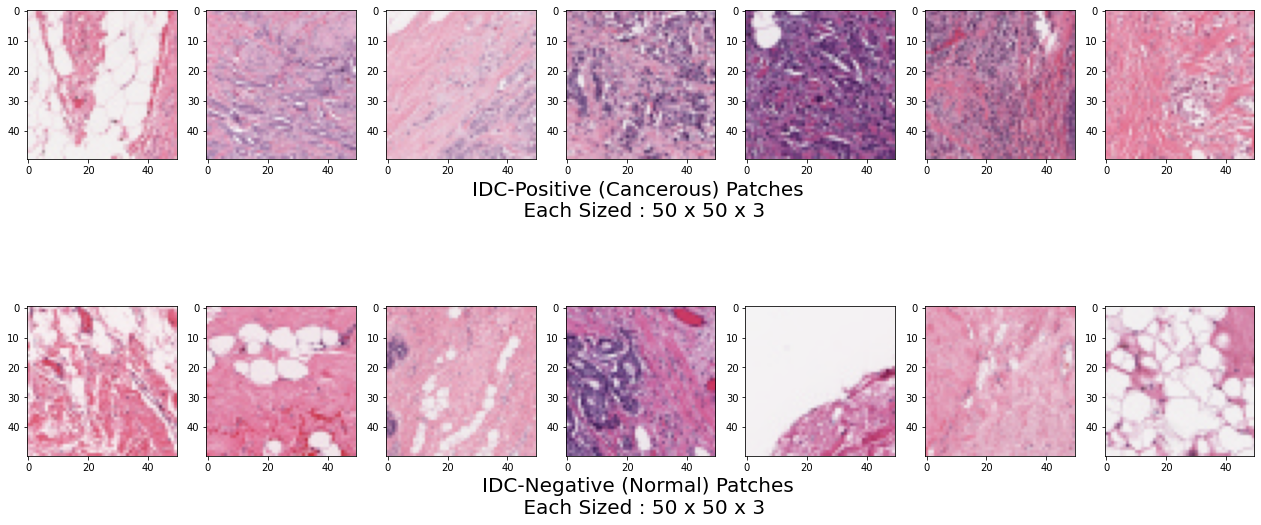

In [ ]:
def visualize_data(idc_positive_patches, non_idc_patches):
    fig, ax = plt.subplots(2, 7, figsize=(22,10))
    for i in range(7):
        ax[0, i].imshow(idc_positive_patches[random.randint(1,len(idc_positive_patches))])
        ax[1, i].imshow(non_idc_patches     [random.randint(1,len(non_idc_patches))])
    ax[0, 3].set_xlabel('IDC-Positive (Cancerous) Patches \n Each Sized : 50 x 50 x 3', fontsize = 20)
    ax[1, 3].set_xlabel('IDC-Negative (Normal) Patches \n Each Sized : 50 x 50 x 3', fontsize = 20)
    plt.show()

visualize_data(idc_positive_patches, non_idc_patches)

## Data Preparation<a class="anchor" id="data_preparation"></a>

* **Normalizing** data since images might have different pixel values and for range (0-255) these values can dramatically affect the model's loss function. To make this alteration more even and less significant, rescaling pixel values to (0.0-1.0) float values. Plus, with most of the libraries, pixel values 0.0-1.0 (float) are just more practical.

In [ ]:
# Normalization and sanity check afterwards.
print('RGB Pixel value of first image before \t= {}'.format(histology_patches[0][0][0]))
histology_patches = histology_patches / 255.0
print('RGB Pixel value of first image after \t= {}'.format(histology_patches[0][0][0]))

RGB Pixel value of first image before 	= [226 164 206]
RGB Pixel value of first image after 	= [0.88627451 0.64313725 0.80784314]


* **Splitting** the data into 12.5% test data, 12.5% validation data and 75% training data. Ensuring there is no oversampling or undersampling after splitting the data, which causes imbalanced learn and we don't want that.

In [ ]:
from sklearn.model_selection import train_test_split

train_s = 0.75

x_train, x_remaining, y_train, y_remaining = train_test_split(histology_patches, labels, random_state=13, train_size=train_s)
x_valid, x_test, y_valid, y_test = train_test_split(x_remaining, y_remaining, test_size=0.5)

x_train_positive = x_train[y_train == 1]
print('[    TRAIN DATA   ] Count of images = {}'.format(len(x_train)))
print('[    TEST DATA    ] Count of images = {}'.format(len(x_test)))
print('[ VALIDATION DATA ] Count of images = {}'.format(len(x_valid)))
print('[    TRAIN DATA   ] Ratio of IDC-Positive to IDC-Negative = {}/{}'.format(len(x_train[y_train == 1]), len(x_train[y_train == 0])))
print('[    TEST DATA    ] Ratio of IDC-Positive to IDC-Negative = {}/{}'.format(len(x_test[y_test == 1]), len(x_test[y_test == 0])))
print('[ VALIDATION DATA ] Ratio of IDC-Positive to IDC-Negative = {}/{}'.format(len(x_valid[y_valid == 1]), len(x_valid[y_valid == 0])))

[    TRAIN DATA   ] Count of images = 4160
[    TEST DATA    ] Count of images = 694
[ VALIDATION DATA ] Count of images = 693
[    TRAIN DATA   ] Ratio of IDC-Positive to IDC-Negative = 2101/2059
[    TEST DATA    ] Ratio of IDC-Positive to IDC-Negative = 337/357
[ VALIDATION DATA ] Ratio of IDC-Positive to IDC-Negative = 350/343


* **Data augmentation** is alteration of the pre-existing training data, in our case image data, by applying some transformations on it. Data augmentation provides additional data which allows model to train on larger number of network parameters and thus a larger neural net as an outcome. This helps to prevent avoiding overfitting since it adds variation and generalization to the data. Augmentation also helps when in situations of scarcity in data, where new data collection is very difficult if not impossible. 

* There are many different types of image data augmentation such as cropping, zooming, adding salt-pepper noise, color alterations, rotation, flipping etc. But I am going to only use orthogonal rotation (90 and 180 degrees rotation) and horizontal/vertical flip techniques while augmenting the data. After appending the already shuffled generated data to the original training data, I will shuffle them just in case.

<a href="https://www.researchgate.net/figure/Data-augmentation-using-semantic-preserving-transformation-for-SBIR_fig2_319413978"><img src="https://i.imgur.com/7cTcxrH.png" alt="Data augmentation using semantic-preserving transformation for SBIR." width=500/></a>

In [ ]:
def rotate_orthogonal(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

train_augmentator = ImageDataGenerator(horizontal_flip=True,
                                       vertical_flip=True,
                                       preprocessing_function=rotate_orthogonal)

def augment_class(is_idc_positive, nump_arr):
    augmented_data= []
    num_augmented = 0
    
    for x_batch in train_augmentator.flow(nump_arr, batch_size=16, shuffle=False):
        augmented_data.append(x_batch)
        num_augmented += 16
        if num_augmented > len(nump_arr) / 2:
            break
        
    return np.concatenate(augmented_data), np.full((num_augmented), is_idc_positive, dtype=np.uint64)

x_aug_pos, y_aug_pos = augment_class(1, x_train[y_train == 1])
x_aug_neg, y_aug_neg = augment_class(0, x_train[y_train == 0])

x_aug = np.append(x_aug_pos, x_aug_neg, axis=0)
y_aug = np.append(y_aug_pos, y_aug_neg, axis=0)
x_aug, y_aug = shuffle(x_aug, y_aug)

x_train = np.append(x_train, x_aug, axis=0)
y_train = np.append(y_train, y_aug, axis=0)
x_train, y_train = shuffle(x_train, y_train)

print('[    TRAIN DATA   ] Count of images = {}'.format(len(x_train)))
print('[    TRAIN DATA   ] Ratio of IDC-Positive to IDC-Negative = {}/{}'.format(len(x_train[y_train == 1]), len(x_train[y_train == 0])))

[    TRAIN DATA   ] Count of images = 6256
[    TRAIN DATA   ] Ratio of IDC-Positive to IDC-Negative = 3157/3099


## Modeling<a class="anchor" id="modeling"></a>

* While training a model (neural network), with traditional machine learning, we must be good at feature engineering meaning knowing what features works very well since it is based on building features with predefined equations or parameters and testing them afterwards to see if they are accurate or not. But nowadays, Convolutional Neural Networks (Deep Learning approach) is getting popular. CNNs are based on the questioning of the traditional machine learning approaches. It asks "Is there a better way to get features works best with our data?", "Can we actually learn the features instead of building and testing them?", "Can we take input image and corresponding mask (which is ground truth) and learn the features works well with our problem?". In deep learning, where features are learned, by each iteration means minimizing the loss function in every iteration to approximate the ideal situation. Especially in complex problems where feature extraction is hard and not so intuitive.

<table><tr>
  <img src="https://i.imgur.com/JcYCYli.png" alt="Deep Learning V. Traditional Machine Learning" width="45%" />
  <img src="https://i.imgur.com/0HSY0n6.png" alt="Deep Learning V. Traditional Machine Learning 2" width="45%" />
</tr></table>


* There is pretrained Convolutional Neural Networks built on cutting-edge advancements in Deep Learning academics but I preferred to implement my on CNN using Keras and tried to find best parameters by trial and error. Adam optimizer is used for the better results in Loss Function. My model consists of one input layer which has neuron size 32, three convolutional layers comes after the input layer with parameters: 256 neruons, 0 dropout; 128 neurons, 0.2 droput; 1024 neurons, 0.5 dropout respectively. A dense layer of 16 neurons, 0.2 dropout is the last layer of my CNN before the classification.

* I defined the Convolutional Neural Network model using Keras:

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session() ## clear model to test with different parameters

INPUT_SHAPE = (50, 50, 3) ## We have 50x50 RGB images
model = Sequential()

## Input Layer
model.add(Conv2D(filters=32, kernel_size=(3,3),
                 activation='relu', input_shape=INPUT_SHAPE))

## We're going to have three convolutional layers
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Dropout(0.2))

model.add(Conv2D(1024, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

## Dense Layer
model.add(Flatten())   ## Dense layer can't accept 2D arrays, making it flat
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))


# Don't use softmax for binary classification
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 256)       73984     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 256)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 10, 128)       0

* In this phase, I trained my model. I got the optimal results when I set the batch size 32 and 20 epochs were enough to settle the loss function and valid accuracy. Also, validation data seperated from the training data significantly increased my accuracy values while I trained my model.

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1,
                    validation_data=(x_valid, y_valid), shuffle=False)

Epoch 1/20
196/196 [==============================] - 5s 24ms/step - loss: 0.6474 - accuracy: 0.6084 - val_loss: 0.5893 - val_accuracy: 0.7388
Epoch 2/20
196/196 [==============================] - 4s 23ms/step - loss: 0.5936 - accuracy: 0.6835 - val_loss: 0.5176 - val_accuracy: 0.7532
Epoch 3/20
196/196 [==============================] - 4s 22ms/step - loss: 0.5485 - accuracy: 0.7369 - val_loss: 0.4962 - val_accuracy: 0.7648
Epoch 4/20
196/196 [==============================] - 4s 22ms/step - loss: 0.5320 - accuracy: 0.7574 - val_loss: 0.5157 - val_accuracy: 0.7475
Epoch 5/20
196/196 [==============================] - 4s 22ms/step - loss: 0.5244 - accuracy: 0.7594 - val_loss: 0.5326 - val_accuracy: 0.7547
Epoch 6/20
196/196 [==============================] - 5s 23ms/step - loss: 0.5228 - accuracy: 0.7607 - val_loss: 0.4925 - val_accuracy: 0.7749
Epoch 7/20
196/196 [==============================] - 4s 22ms/step - loss: 0.5152 - accuracy: 0.7623 - val_loss: 0.4826 - val_accuracy: 0.7734

## Evaluation<a class="anchor" id="evaluation"></a>

* First plot the training loss, validation loss, training accuracy and validation accuracy to get our first insight about the efficiency of the model.

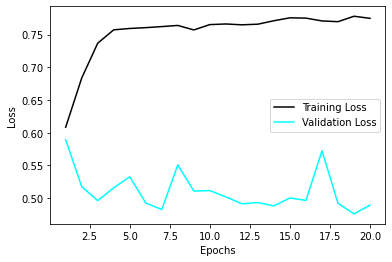

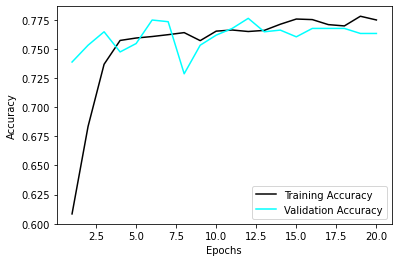

In [ ]:
loss = history.history['accuracy']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'black', label='Training Loss')
plt.plot(epochs, val_loss, 'cyan', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, 'black', label='Training Accuracy')
plt.plot(epochs, valid_accuracy, 'cyan', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

* Calculating the overall accuracy of the model on all test data and testing my model on random 15 breast histology patches:

22/22 [==============================] - 0s 11ms/step - loss: 0.5428 - accuracy: 0.7450


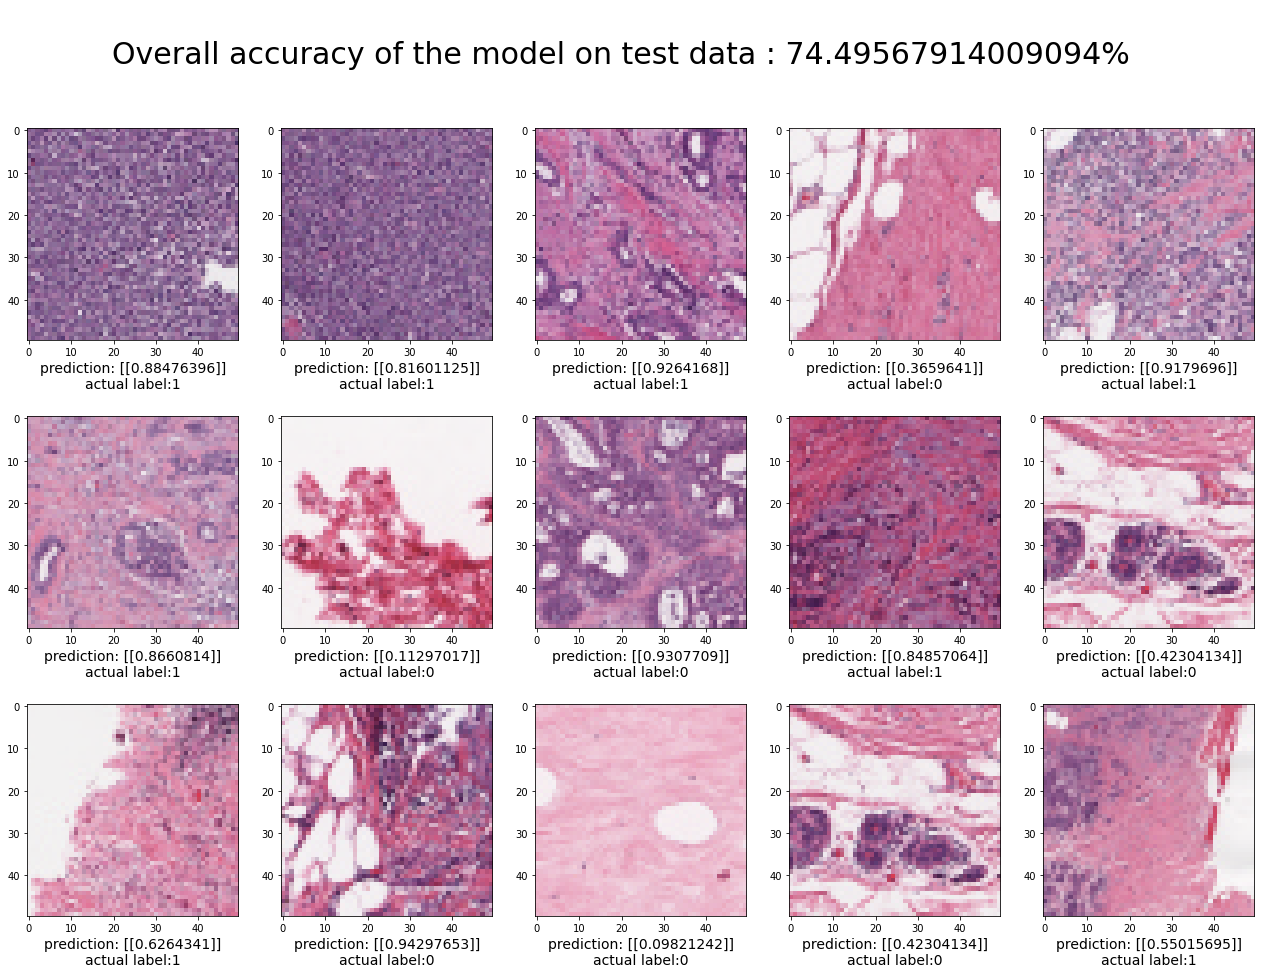

In [ ]:
_, accuracy = model.evaluate(x_test, y_test)
accuracy_string = ('\nOverall accuracy of the model on test data : ' + str(accuracy * 100.0) + '%')

def random_test():
    fig, ax = plt.subplots(3, 5, figsize=(22,15))
    for k in range(3):
        for i in range(5):
            n = random.randint(0, len(x_test) - 1)
            img = x_test[n]
            input_image = np.expand_dims(img, axis=0)
            ax[k, i].imshow(img)
            ax[k, i].set_xlabel('prediction: {}\nactual label:{}'.format(model.predict(input_image, verbose=False), y_test[n]), fontsize = 14)
    fig.suptitle(accuracy_string, fontsize=30)
    plt.show()

random_test()

* In this part of the evaluation, I plotted the confusion matrix of my model on test data. In confusion matrix we compare labels with the predictions to see false positives, false negatives, true positives and true negatives to get more insight about efficiency of our model. Since I used 'sigmoid' activation, results were not as actual (binary) labels but probabilies. But to build a confusion matrix we need actual 'classifications' as we test a data with our model to classify it. For this reason I defined a threshold as 0.5 and casted the probabilities of 'sigmoid' activation into actual labels. As  you can see, model is relatively good at classifying IDC-Positive patches compared to classifying IDC-Negative patches.

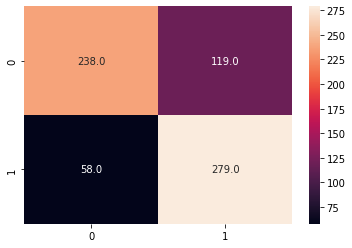

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn

threshold = 0.5

y_predict = (model.predict(x_test, verbose=False) >= threshold).astype('int')
conf_matr = confusion_matrix(y_test, y_predict)
seaborn.heatmap(conf_matr, annot=True, fmt=".1f")


Receiver Operating Characteristic (ROC) curve is a metric for assigning performance of a ML model. Area under the ROC Curve towards X-axis (AUC) (think like taking integral of a function) provides us insight about the model's performance for classification. Significant AUC means better performance for distinguishing classes. Our model is definitely not best performing model on the earth but it is not a bad model either if we consider below chart for ROC curves and their meanings.


22/22 [==============================] - 0s 9ms/step


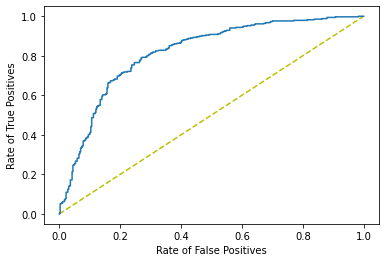

In [ ]:
from sklearn.metrics import roc_curve
y_predict = model.predict(x_test).ravel()

false_p_rate, true_p_rate, thresholds = roc_curve(y_test, y_predict)
plt.figure(1)
plt.plot([0,1], [0,1], 'y--')
plt.plot(false_p_rate, true_p_rate)
plt.xlabel('Rate of False Positives')
plt.ylabel('Rate of True Positives')
plt.show()

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Roc-draft-xkcd-style.svg/640px-Roc-draft-xkcd-style.svg.png" alt="The ROC space for a better and worse classifier." width="500"/>

## References<a class="anchor" id="references"></a>

* Angel Cruz-Roa et al. (2014) Automatic detection of invasive ductal carcinoma in whole slide images with convolutional neural networks. Proc.SPIE. doi: 10.1117/12.2043872.
* Invasive (infiltrating) ductal carcinoma: Grades, treatments &amp; prognosis (no date) Cleveland Clinic. Available at: [Online Link](https://my.clevelandclinic.org/health/diseases/22117-invasive-ductal-carcinoma-idc#:~:text=Invasive%20ductal%20carcinoma%20(IDC)%20is,has%20a%20high%20survival%20rate) (Accessed: December 31, 2022).
* Invasive ductal carcinoma (IDC): Grade, symptoms & diagnosis. Available at: [Online Link](https://www.breastcancer.org/types/invasive-ductal-carcinoma) (Accessed: December 31, 2022).
* Simjeg (2017) Breast histology images, Kaggle. Available at: [Online Link](https://www.kaggle.com/datasets/simjeg/lymphoma-subtype-classification-fl-vs-cll) (Accessed: December 31, 2022).
* Ductal carcinoma in situ: Symptoms, causes &amp; treatment (no date) Cleveland Clinic. Available at: [Online Link](https://my.clevelandclinic.org/health/diseases/17869-ductal-carcinoma-in-situ-dcis) (Accessed: December 31, 2022).
* Data augmentation using semantic-preserving transformation for SBIR ... (no date). Available at: [Online Link](https://www.researchgate.net/figure/Data-augmentation-using-semantic-preserving-transformation-for-SBIR_fig2_319413978) (Accessed: December 31, 2022).
* Security Team (Xantaro Deutschland GmbH) -  25. October 2018 (2022) Ai, Machine Learning and deep learning?: &nbsp;xantaro, Xantaro. Available at: [Online Link](https://www.xantaro.net/en/tech-blogs/machine-and-deep-learning-cybersecurity/) (Accessed: January 2, 2023).
* Author: James McDermott (no date) Convolutional Neural Networks - image classification W. Keras, Learn Data Science - Tutorials, Books, Courses, and More. Available at: [Online Link](https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/) (Accessed: January 3, 2023).
* File:roc-draft-xkcd-style.svg (no date) Wikimedia Commons. Available at: [Online Link](https://commons.wikimedia.org/wiki/File:Roc-draft-xkcd-style.svg) (Accessed: January 3, 2023).


**Disclaimer!** <font color='grey'>This notebook was prepared by Sencer Kaya as a term project for the *BBM467 - Data Intensive Applications* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>